<a href="https://colab.research.google.com/github/Mike030668/MIPT_magistratura/blob/main/NLP/DZ_2_text_classification_roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание

Для закрепления материала модуля предлагаем вам поучаствовать в учебном [Kaggle-соревновании](https://www.kaggle.com/competitions/unit-3-nlp-txt-classification/data).

Вам необходимо решить задачу классификации текстов, используя рекуррентные сети.
______

При выполнении проекта разрешается пользоваться любыми средствами для векторных представлений текстов, кроме трансформеров, и любыми вариантами рекуррентных сетей. Для достижения наилучшего результата уделите внимание подбору гиперапарметров как в плане архитектуры, так и в плане обучения модели.
______

Критерии самооценивания проекта:

- общее качество кода и следование PEP-8;
- использование рекуррентных сетей;
- итоговое значение метрики качества.

# Подключение к Kaggle

In [ ]:
api_token = {"username":"mikepuzitsky","key":"4dfb8b2919eb3a2ec341589ef092065f"}  #{"username":"...","key":"..."}

import json

with open('/content/kaggle.json', 'w') as file:
  json.dump(api_token, file)

In [ ]:
# Загрузка датасета с Кеггла
!pip install kaggle -q
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.12 -q
!kaggle --version

# Загрузка данных соревнования

In [ ]:
!kaggle competitions download -c unit-3-nlp-txt-classification
!unzip '/content/unit-3-nlp-txt-classification.zip' -d'/content/data/'

In [ ]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

os.listdir() # корневая папка

## Читаем все в датафреймы.

In [ ]:
INPUT_PATH = '/content/data'  # папка с данными
# данные для обучения
main_ds = pd.read_csv(os.path.join(INPUT_PATH, 'train.csv'), index_col=0)
# тестовые данные
test_ds = pd.read_csv(os.path.join(INPUT_PATH, 'test.csv'), index_col=0)
# пример для загрузки ответов
sample_submission = pd.read_csv(os.path.join(INPUT_PATH, 'sample_submission.csv'))
# размер данных
main_ds.shape, test_ds.shape, sample_submission.shape

In [ ]:
# train dataset
main_ds.head()

In [ ]:
main_ds.sample(1).Text.tolist()[0]

In [ ]:
# train dataset Sentiment.value_counts()
main_ds.Sentiment.value_counts()

In [ ]:
# test dataset
main_ds.head()

In [ ]:
# sample_submission
print(sample_submission.Sentiment.value_counts())
print()
sample_submission.head()


## Импорты и константы

In [ ]:
import time
import re
from tqdm import tqdm



In [ ]:
NUM_CLASSES = len(main_ds.Sentiment.value_counts().index)
print(f'NUM_CLASSES = {NUM_CLASSES}')


## Чистка и предобработка

In [ ]:
# пропуски
main_ds.isna().sum()

Есть совсем немного (от 4 до 6) NaNов в 41159 строках. Проще от них избавиться.

In [ ]:
# удаляем
main_ds = main_ds.dropna()
main_ds.isna().sum()

## Есть ли баланс в данных?

In [ ]:
# давайте посмотрим распределение оценок
import matplotlib.pyplot as plt
%matplotlib inline
# value_counts () - a command that allows you to calculate the number of unique values
vc = main_ds.Sentiment.value_counts()
vc = vc.sort_index()
print(vc)
vc.plot(kind='bar');

Самый частый класс больше самого редкого в два раза. Пока как есть пробуем.

На следующем этаме можно добавить аугментацию

Посмотрим на длину текстов.

In [ ]:
lens = main_ds.Text.apply(lambda s: len(s))
lens.plot.hist(bins=50);

In [ ]:
lens.quantile(0.95), max(lens)

In [ ]:
lens = main_ds.Text.apply(lambda s: len(s))
lens.plot.hist(bins=50);

In [ ]:
lens.quantile(0.95), max(lens)

# Sentences cleaning

Подберем то, что мы очищаем в данных

## abbreviaturs clearning

In [ ]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
abbreviations = {
    "Â": "'",
    "$" : " dollar ",
    "€" : " euro ",
    "Â" : "",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired",
}

In [ ]:
def convert_abbrev(text):
    new_text = ''
    for word in text.split():
      if word.lower() in abbreviations.keys():
        new_text += ' ' + word[0] + abbreviations[word.lower()][1:]
      else:
        new_text += ' ' + word
    return ' '.join(new_text.split())

In [ ]:
#sentence = main_ds.sample().Text.values[0]
sentence = "So ygtr now weÂre NOT supposed to go to the grocery store??  Really? Did I miss this before? #TrumpPressBriefing #COVID2019"
print(sentence)
print()
sentence = convert_abbrev(sentence)
print(sentence)

## Phrases with apostrophes

Словосочетания с апострофами в английском лушче раскрыть.

In [ ]:
contraction_dict = {"ain't": "is not",
                    "aren't": "are not",
                    "can't": "can not",
                    "'cause": "because",
                    "could've": "could have",
                    "couldn't": "could not",
                    "didn't": "did not",
                    "doesn't": "does not",
                    "don't": "do not",
                    "hadn't": "had not",
                    "hasn't": "has not",
                    "haven't": "have not",
                    "he'd": "he would",
                    "he'll": "he will",
                    "he's": "he is",
                    "how'd": "how did",
                    "how'd'y": "how do you",
                    "how'll": "how will",
                    "how's": "how is",
                    "I'd": "I would",
                    "I'd've": "I would have",
                    "I'll": "I will",
                    "I'll've": "I will have",
                    "I'm": "I am",
                    "I've": "I have",
                    "i'd": "i would",
                    "i'd've": "i would have",
                    "i'll": "i will",
                    "i'll've": "i will have",
                    "i'm": "i am",
                    "i've": "i have",
                    "isn't": "is not",
                    "it'd": "it would",
                    "it'd've": "it would have",
                    "it'll": "it will",
                    "it'll've": "it will have",
                    "it's": "it is",
                    "let's": "let us",
                    "ma'am": "madam",
                    "mayn't": "may not",
                    "might've": "might have",
                    "mightn't": "might not",
                    "mightn't've": "might not have",
                    "must've": "must have",
                    "mustn't": "must not",
                    "mustn't've": "must not have",
                    "needn't": "need not",
                    "needn't've": "need not have",
                    "o'clock": "of the clock",
                    "oughtn't": "ought not",
                    "oughtn't've": "ought not have",
                    "shan't": "shall not",
                    "sha'n't": "shall not",
                    "shan't've": "shall not have",
                    "she'd": "she would",
                    "she'd've": "she would have",
                    "she'll": "she will",
                    "she'll've": "she will have",
                    "she's": "she is",
                    "should've": "should have",
                    "shouldn't": "should not",
                    "shouldn't've": "should not have",
                    "so've": "so have",
                    "so's": "so as",
                    "this's": "this is",
                    "that'd": "that would",
                    "that'd've": "that would have",
                    "that's": "that is",
                    "there'd": "there would",
                    "there'd've": "there would have",
                    "there's": "there is",
                    "here's": "here is",
                    "they'd": "they would",
                    "they'd've": "they would have",
                    "they'll": "they will",
                    "they'll've": "they will have",
                    "they're": "they are",
                    "they've": "they have",
                    "to've": "to have",
                    "wasn't": "was not",
                    "we'd": "we would",
                    "we'd've": "we would have",
                    "we'll": "we will",
                    "we'll've": "we will have",
                    "we're": "we are",
                    "we've": "we have",
                    "weren't": "were not",
                    "what'll": "what will",
                    "what'll've": "what will have",
                    "what're": "what are",
                    "what's": "what is",
                    "what've": "what have",
                    "when's": "when is",
                    "when've": "when have",
                    "where'd": "where did",
                    "where's": "where is",
                    "where've": "where have",
                    "who'll": "who will",
                    "who'll've": "who will have",
                    "who's": "who is",
                    "who've": "who have",
                    "why's": "why is",
                    "why've": "why have",
                    "will've": "will have",
                    "won't": "will not",
                    "won't've": "will not have",
                    "would've": "would have",
                    "wouldn't": "would not",
                    "wouldn't've": "would not have",
                    "y'all": "you all",
                    "y'all'd": "you all would",
                    "y'all'd've": "you all would have",
                    "y'all're": "you all are",
                    "y'all've": "you all have",
                    "you'd": "you would",
                    "you'd've": "you would have",
                    "you'll": "you will",
                    "you'll've": "you will have",
                    "you're": "you are",
                    "you've": "you have"}

In [ ]:
def convert_contractions(text):
    new_text = ''
    for word in text.split():
      if word.lower() in contraction_dict.keys():
        new_text += ' ' + word[0] + contraction_dict[word.lower()][1:]
      else:
        new_text += ' ' + word
    return ' '.join(new_text.split())

In [ ]:
sentence = "We're running as much product as we can, harvesting as many chickens as we can, (and) we are working Saturdays if we have the supply" #
print(sentence)
print()
print(convert_contractions(sentence))

##Convert Emojis

In [ ]:
!pip install demoji -q

In [ ]:
import demoji

demoji.download_codes()

In [ ]:
#converting Emojis
def convert_emoji(text):
  new_text = ''
  for word in text.split():
    emj = demoji.findall_list(word)
    if len(emj):
      new_text+=' ' + ''.join((c +' ') for c in emj)
    else: new_text+=' ' +word
  return new_text

In [ ]:
sentence = main_ds.sample().Text.values[0] + "\U0001F600-\U0001F64F"
print(sentence)
print()
print(convert_emoji(sentence))

## Remove special characters

In [ ]:
import string
from bs4 import BeautifulSoup
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

#Removing URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

#Removing the noisy text
def denoise_text(text):
    text = remove_URL(text)
    text = remove_between_square_brackets(text)
    text = remove_punct(text)
    return text

In [ ]:
sentence = main_ds.sample().Text.values[0]
print(sentence)
print()
print(denoise_text(sentence))

In [ ]:
def remove_special_characters(text, remove_digits=True):
    text = re.sub('http://\S+|https://\S+|www.\S+|\n|#|\r', '', text)
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text.strip()

In [ ]:
re.sub('[^a-zA-z\s]', '', text).strip()

In [ ]:
print(sentence)
print()
remove_special_characters(sentence)

In [ ]:
def convert2several_words(text):
  return "".join((" " + w if (w.isupper() and i) else w) for i, w in enumerate(text))#.strip().split() #' '.join(w for w in re.findall('[A-Z][^A-Z]*', text))

In [ ]:
def convert2several_words(text):
  new_text = ''
  for word in text.split():
    if not word.isupper():
      word = "".join((" " + w if (w.isupper() and i) else w) for i, w in enumerate(word))
      new_text+= " " + word
    else:
      new_text+=' '+word
  return ' '.join(new_text.split())

In [ ]:
sentence = 'With apologies this is that Talkwalker post consumer trends for content in coronavirus times DigitalMarketing'
convert2several_words(sentence)

## Mix clearing

In [ ]:
#Collect all functions
def clean_text(text):
    text = remove_URL(text)
    text = convert_emoji(text)
    text = convert_abbrev(text)
    text = convert_contractions(text)
    text = convert2several_words(text)
    text = denoise_text(text)
    ext = remove_special_characters(text)
    #text = remove_stopwords(text)
    return ' '.join(text.split())

In [ ]:
sentence = main_ds.sample().Text.values[0]
print(sentence)
print()
print(clean_text(sentence))

In [ ]:
%timeit
main_ds['Text_clean'] = main_ds['Text'].apply(clean_text)
test_ds['Text_clean'] = test_ds['Text'].apply(clean_text)
main_ds.head()

In [ ]:
main_ds.sample(10)

# Look again

In [ ]:
def length(text):
    '''a function which returns the length of text'''
    return len(text)

Сьлвари для первода из имени класса в номер класса и обратно

In [ ]:
dict_lbl_to_sent = {k: v for k, v in enumerate(main_ds['Sentiment'].unique())}
dict_sent_to_lbl = {v: k for k, v in dict_lbl_to_sent.items()}
print(f'Encoded sentiment values: {dict_sent_to_lbl}')

Добавим номера классов

In [ ]:
main_ds['Label'] = main_ds['Sentiment'].apply(lambda x: dict_sent_to_lbl[x])

Добавим длину текстов

In [ ]:
main_ds['length_text_clean'] = main_ds['Text_clean'].apply(length)
test_ds['length_text_clean'] = test_ds['Text_clean'].apply(length)

## Number of characters in text

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 50
plt.hist(main_ds.Text.apply(length), alpha = 0.6, bins=bins, label='Before cleaning text')
plt.hist(main_ds['length_text_clean'], alpha = 0.6, bins=bins, label='After cleaning text')
plt.xlabel('length_text')
plt.ylabel('numbers')
plt.title('Number of characters in text')
plt.legend(loc='upper right')
plt.grid()
plt.show()

## Number of words in a text

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 30
text_len=main_ds['Text'].str.split().map(lambda x: len(x))
text_len_clean=main_ds['Text_clean'].str.split().map(lambda x: len(x))
plt.hist(text_len, alpha = 0.6, bins=bins, label='Before cleaning text')
plt.hist(text_len_clean, alpha = 0.6, bins=bins, label='After cleaning text')
plt.xlabel('length')
plt.ylabel('numbers')
plt.title('Number of words in a text')
plt.legend(loc='upper right')
plt.grid()
plt.show()

## Removing blank lines


In [ ]:
main_ds[main_ds.length_text_clean == 0]

In [ ]:
main_ds = main_ds.drop(main_ds[main_ds.length_text_clean == 0].index)

В тестовом стоит также почистить перед предиктом, а этим поставить - `Neutral`

In [ ]:
main_ds[main_ds.length_text_clean == 4]

In [ ]:
# value_counts () - a command that allows you to calculate the number of unique values
vc = main_ds.Sentiment.value_counts()
vc = vc.sort_index()
print(vc)
vc.plot(kind='bar');

Дисбаланс класссов можно решить через аугментацию в следующем варианте

# RoBERTa

https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb#scrollTo=nvXxpfNCGER2

In [ ]:
!pip install  transformers -q

In [ ]:
import transformers
from transformers import pipeline
from transformers import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

## DataLoader, Dataset

In [ ]:
import torch
from torch import nn
import torch.optim as optim

In [ ]:
new_df = main_ds[['Text_clean', 'Label']]

In [ ]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.Text_clean
        self.targets = self.data.Label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_size = 0.8
MAX_LEN = 126
train_data=new_df.sample(frac=train_size, random_state=200)
valid_data=new_df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("VALID Dataset: {}".format(valid_data.shape))

training_set = SentimentData(train_data, tokenizer, MAX_LEN)
valid_set = SentimentData(valid_data, tokenizer, MAX_LEN)

In [ ]:
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 16

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

valid_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
valid_loader = DataLoader(valid_set, **valid_params)

In [ ]:
dataiter = iter(training_loader)
sample = next(dataiter)

In [ ]:
print('Sample ids input size', sample['ids'].size())
print('Sample mask input: \n', sample['mask'].size())
print('Sample token_type_ids input: \n', sample['token_type_ids'].size())
print('Sample targets input: \n', sample['targets'].size())
print('\nSample ids input size', sample['ids'])
print('Sample label: \n', sample['targets'])

# Build model

<a id='section05'></a>
### Fine Tuning the Model

After all the effort of loading and preparing the data and datasets, creating the model and defining its loss and optimizer. This is probably the easier steps in the process.

Here we define a training function that trains the model on the training dataset created above, specified number of times (EPOCH), An epoch defines how many times the complete data will be passed through the network.

Following events happen in this function to fine tune the neural network:
- The dataloader passes data to the model based on the batch size.
- Subsequent output from the model and the actual category are compared to calculate the loss.
- Loss value is used to optimize the weights of the neurons in the network.
- After every 5000 steps the loss value is printed in the console.

As you can see just in 1 epoch by the final step the model was working with a loss of 0.8141926634122427.

In [ ]:
class Roberta_Class(torch.nn.Module):
    def __init__(self, num_classes, hidden_size=768, num_layers=3):
        super(Roberta_Class, self).__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-base")

        #self.lstm = torch.nn.LSTM(input_size=768, hidden_size=hidden_size,
                         #num_layers=num_layers, batch_first=True)

        self.pre_classifier = torch.nn.Linear(2304, 128) #hidden_size, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(128, num_classes) # 768, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.roberta(input_ids=input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        avg_pool = torch.mean(hidden_state, 1)
        max_pool, _ = torch.max(hidden_state, 1)
        conc = torch.cat((avg_pool, max_pool, hidden_state[:, 0]), 1)

        #hidden_state, _ = self.lstm(hidden_state)
        #pooler = hidden_state[:, 0]

        pooler = self.pre_classifier(conc)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = Roberta_Class(NUM_CLASSES)
model.to(device)

# Сonstruction train loop

Принцип построение - https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/02_pytorch_classification.ipynb#scrollTo=C_EsAE3VHC7-

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Functions

In [ ]:
import torch

def f1_accuracy(preds, labels):

    preds_np = preds.detach().cpu().numpy()
    labels_np = labels.detach().cpu().numpy()

    num_classes = preds.size(1)

    preds = torch.argmax(preds, dim=1)

    f1_scores = []
    for class_idx in range(num_classes):
        TP = torch.sum((preds == class_idx) & (labels == class_idx))
        FP = torch.sum((preds == class_idx) & (labels != class_idx))
        FN = torch.sum((preds != class_idx) & (labels == class_idx))

        precision = TP / (TP + FP + 1e-8)
        recall = TP / (TP + FN + 1e-8)
        class_f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

        f1_scores.append(class_f1)

    macro_f1 = sum(f1_scores) / len(f1_scores)

    return macro_f1


# Example usage:
batch_size = 16
num = 5

# Generate some random predictions and labels (assuming batch size of 16)
preds = torch.randn(batch_size, num)  # Random prediction scores
labels = torch.randint(0, num, (batch_size,))  # Random true labels

f1_score = f1_accuracy(preds, labels)
print("Macro F1 Score:", f1_score)



Macro F1 Score: tensor(0.1371)


In [ ]:
class RunningAverage:
    """
    Class to save and update the running average
    """

    def __init__(self) -> None:
        self.count = 0
        self.total = 0.0

    def update(self, n: float) -> None:
        """
        Updates running average with new value
        Parameters
        ----------
        n (float): value to add to the running average
        """
        self.total += n
        self.count += 1

    def __call__(self) -> float:
        """
        Returns current running average
        Returns
        -------
        running_avg (float): Current running average
        """
        running_avg = self.total / (self.count + 1e-15)
        return running_avg

In [ ]:
import gc
import sys
def train(model, iterator, optimizer, scheduler, criterion, accuracy):

    epoch_loss = 0
    epoch_acc = 0

    loss_avg = RunningAverage()

    model.train()
    with tqdm(total=len(iterator), leave=False, file=sys.stdout) as t:
        #t.set_description()#f'Epoch {e + 1}')
        for _, data in enumerate(iterator, 0):
            # Force the garbage collection
            torch.cuda.empty_cache()
            gc.collect()

            # Put data to target device
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)

            #optimizer.zero_grad()
            model.zero_grad()

            outputs = model(ids, mask, token_type_ids)
            loss = criterion(outputs, targets)
            loss_avg.update(loss.item())

            predictions = torch.softmax(outputs, dim=1)
            acc = accuracy(predictions, targets) #torch.argmax inside for F1

            t.set_postfix({'stats': f'train_loss: {loss_avg():.4f}'})
            t.update()
            stats_time_elapsed = t.format_interval(t.format_dict['elapsed'])

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            cur_lr = scheduler.get_lr()[0]
            scheduler.step()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), cur_lr

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LR_RATE = 1e-05
optimizer = optim.SGD(model.parameters(), lr=LR_RATE)

lr_scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR_RATE, max_lr=LR_RATE*3,
                                           step_size_up=5,mode="exp_range",gamma=0.85)

In [ ]:
# Calculate class frequencies
class_frequencies = main_ds.Label.value_counts().sort_index()

# Calculate class weights inversely proportional to class frequencies
total_samples = len(main_ds)
class_weights = total_samples / (len(class_frequencies) * class_frequencies)

# Convert class weights to a PyTorch tensor
class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float)

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
EPOCHS = 1
for epoch in range(EPOCHS):
   train_loss, train_acc, ep_lr = train(model, training_loader, optimizer,
                                         lr_scheduler, criterion, f1_accuracy)

In [ ]:
train_loss, train_acc

(1.6150420920378497, 0.17821345693885238)

In [ ]:
def evaluate(model, iterator, criterion, accuracy):

    epoch_loss = 0
    epoch_acc = 0

    ### Testing
    model.eval()

    with torch.no_grad():

        for _,data in tqdm(enumerate(iterator, 0)):

            # Put data to target device
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)

            outputs = model(ids, mask, token_type_ids)
            loss = criterion(outputs, targets)

            predictions = torch.softmax(outputs, dim=1)
            acc = accuracy(predictions, targets) #torch.argmax inside for F1

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
evaluate(model, valid_loader, criterion, f1_accuracy)

515it [00:34, 15.13it/s]


(1.6099820819873254, 0.0783893430261936)

In [ ]:
def predict(model, iterator):

    ### Testing
    model.eval()

    predicts = []

    with torch.no_grad():
          for _, data in tqdm(enumerate(iterator, 0)):
            # Put data to target device
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device,
                                                       dtype = torch.long)


            outputs = model(ids, mask, token_type_ids)
            test_pred = torch.softmax(outputs, dim=1)
            test_pred = torch.argmax(test_pred, dim=1)

            # 3. Caculate loss/accuracy
            predicts.append(test_pred.cpu().numpy())

    return np.hstack(predicts)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def plot_graph(epochs, losses, accuracy, learning_rate):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    axs[0].set_title("Train/Validation Loss")
    axs[0].plot(list(np.arange(epochs) + 1), losses[0], label='train')
    axs[0].plot(list(np.arange(epochs) + 1), losses[1], label='validation')
    axs[0].set(xlabel='num_epochs', ylabel='loss')

    axs[1].set_title("Train/Validation Accuracy")
    axs[1].plot(list(np.arange(epochs) + 1), accuracy[0], label='train')
    axs[1].plot(list(np.arange(epochs) + 1), accuracy[1], label='validation')
    axs[1].set(xlabel='num_epochs', ylabel='acc')

    axs[2].set_title("History learning_rate")
    axs[2].plot(list(np.arange(epochs) + 1), learning_rate)
    axs[2].set(xlabel='num_epochs', ylabel='lr')

# Run the model

[CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss)_
criterion combines ``nn.LogSoftmax()`` and ``nn.NLLLoss()`` in a single class.
It is useful when training a classification problem with C classes.
[SGD](https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html)_
implements stochastic gradient descent method as the optimizer. The initial
learning rate is set to 5.0.
[StepLR](https://pytorch.org/docs/master/_modules/torch/optim/lr_scheduler.html#StepLR)_
is used here to adjust the learning rate through epochs.




## Calculate class weights

In [ ]:
# Calculate class frequencies
class_frequencies = main_ds.Label.value_counts().sort_index()

# Calculate class weights inversely proportional to class frequencies
total_samples = len(main_ds)
class_weights = total_samples / (len(class_frequencies) * class_frequencies)

# Convert class weights to a PyTorch tensor
class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float)

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LR_RATE = 0.001
optimizer = optim.SGD(model.parameters(), lr=LR_RATE)

lr_scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR_RATE, max_lr=LR_RATE*3,
                                           step_size_up=5,mode="exp_range",gamma=0.85)

## Start train

In [ ]:
N_EPOCHS = 5
EPS = 0.95


JDUN_TRAIN = 3
JDUN_END = 10

try:
  if best_valid_loss and best_valid_acc:
    pass
except:
    best_valid_loss = float('inf')
    best_valid_acc = 0.

hist_train_loss, hist_valid_loss, hist_train_acc, hist_valid_acc = [], [], [], []
hist_lr = []

path_bestacc_model = 'best_acc_model.pt'
path_bestloss_model = 'best_loss_model.pt'

wait_train = 0
wait2end = 0

model_saved = True

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc, ep_lr = train(model, training_loader, optimizer,
                                         lr_scheduler, criterion, f1_accuracy)
    hist_train_loss.append(train_loss)
    hist_train_acc.append(train_acc)

    valid_loss, valid_acc = evaluate(model, valid_loader, criterion,
                                     f1_accuracy)
    hist_valid_loss.append(valid_loss)
    hist_valid_acc.append(valid_acc)
    hist_lr.append(ep_lr)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    text_add = ''
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path_bestloss_model)

        model_saved = True
        text_add = ' - save best_loss_model'
        wait2end = 0
        wait_train = 0
        k = 0

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), path_bestacc_model)

        model_saved = True
        text_add += ' - save best_acc_model'
        wait2end = 0
        wait_train = 0
        k = 1

    else:
        wait_train+=1


    if wait_train > JDUN_TRAIN and model_saved:
       if k == 0:
         model.load_state_dict(torch.load(path_bestloss_model))
         text_add = ' - load best_loss_model'

       elif k == 1:
         model.load_state_dict(torch.load(path_bestacc_model))
         text_add = ' - load best_acc_model'
       LR_RATE *= EPS
       lr_scheduler = optim.lr_scheduler.CyclicLR(optimizer,
                                                  base_lr=LR_RATE,
                                                  max_lr=LR_RATE*3,
                                                  step_size_up = 3,
                                                  mode="exp_range",
                                                  gamma=0.85)
       wait_train = 0
       wait2end+=1

    print(f'Epoch: {epoch+1:02} | with lr: {ep_lr:.9f} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain_Loss: {train_loss:.3f} | Train_Acc: {train_acc*100:.2f}%  Val_Loss: {valid_loss:.3f} | Val_Acc: {valid_acc*100:.2f}%' + text_add)

    if wait2end > JDUN_END:

      if k == 0:
        model.load_state_dict(torch.load(path_bestloss_model))
        text_add = ' - load best_loss_model'

      elif k == 1:
        model.load_state_dict(torch.load(path_bestacc_model))
        text_add = ' - load best_acc_model'

      print('Stop train, do not best fitness'+ text_add)

      break

515it [00:59,  8.63it/s]


Epoch: 01 | with lr: 0.001000000 | Epoch Time: 17m 47s
	Train_Loss: 1.249 | Train_Acc: 38.55%  Val_Loss: 1.035 | Val_Acc: 42.05% - save best_loss_model - save best_acc_model


515it [00:58,  8.83it/s]


Epoch: 02 | with lr: 0.001000000 | Epoch Time: 17m 37s
	Train_Loss: 0.889 | Train_Acc: 61.13%  Val_Loss: 0.880 | Val_Acc: 53.86% - save best_loss_model - save best_acc_model


515it [00:57,  8.88it/s]


Epoch: 03 | with lr: 0.001000000 | Epoch Time: 17m 30s
	Train_Loss: 0.748 | Train_Acc: 68.11%  Val_Loss: 0.688 | Val_Acc: 66.36% - save best_loss_model - save best_acc_model


515it [00:58,  8.84it/s]


Epoch: 04 | with lr: 0.001000000 | Epoch Time: 17m 29s
	Train_Loss: 0.650 | Train_Acc: 72.96%  Val_Loss: 0.645 | Val_Acc: 69.36% - save best_loss_model - save best_acc_model


515it [00:58,  8.86it/s]

Epoch: 05 | with lr: 0.001000000 | Epoch Time: 17m 28s
	Train_Loss: 0.577 | Train_Acc: 76.03%  Val_Loss: 0.727 | Val_Acc: 62.12%


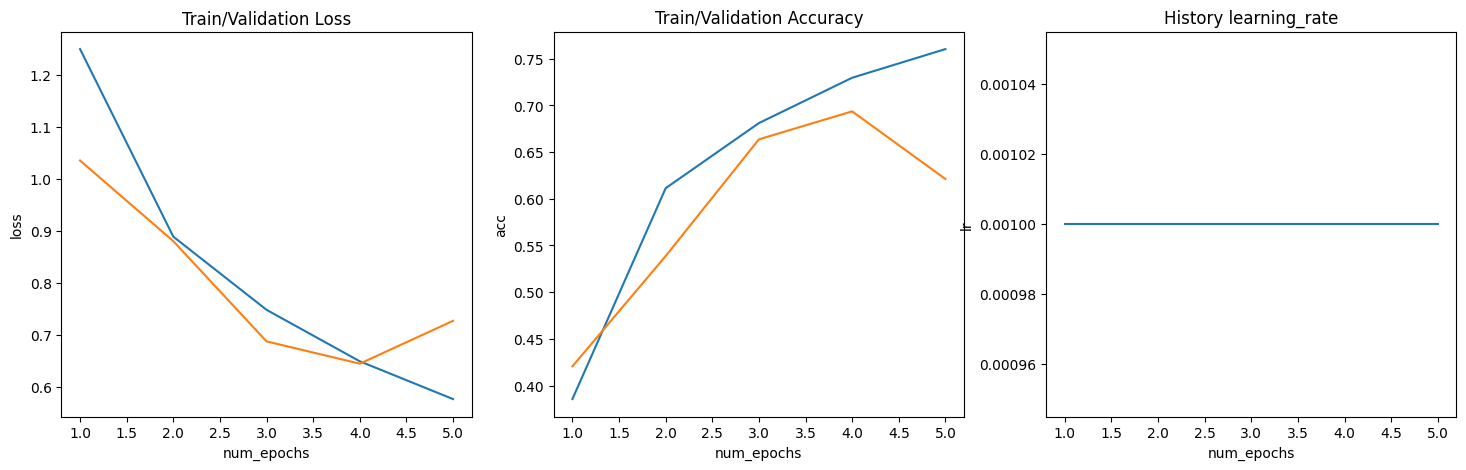

In [ ]:
train_ephs = len(hist_train_loss)
losses = (hist_train_loss, hist_valid_loss)
accuracy = (hist_train_acc, hist_valid_acc)
plot_graph(train_ephs, losses, accuracy, hist_lr)

## Next train

In [ ]:
N_EPOCHS = 50
EPS = 0.95


JDUN_TRAIN = 1
JDUN_END = 5

try:
  if best_valid_loss and best_valid_acc:
    pass
except:
    best_valid_loss = float('inf')
    best_valid_acc = 0.

hist_train_loss, hist_valid_loss, hist_train_acc, hist_valid_acc = [], [], [], []
hist_lr = []

path_bestacc_model = 'best_acc_model.pt'
path_bestloss_model = 'best_loss_model.pt'

wait_train = 0
wait2end = 0

model_saved = True

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc, ep_lr = train(model, training_loader, optimizer,
                                         lr_scheduler, criterion, f1_accuracy)
    hist_train_loss.append(train_loss)
    hist_train_acc.append(train_acc)

    valid_loss, valid_acc = evaluate(model, valid_loader, criterion,
                                     f1_accuracy)
    hist_valid_loss.append(valid_loss)
    hist_valid_acc.append(valid_acc)
    hist_lr.append(ep_lr)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    text_add = ''
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path_bestloss_model)

        model_saved = True
        text_add = ' - save best_loss_model'
        wait2end = 0
        wait_train = 0
        k = 0

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), path_bestacc_model)

        model_saved = True
        text_add += ' - save best_acc_model'
        wait2end = 0
        wait_train = 0
        k = 1

    else:
        wait_train+=1


    if wait_train > JDUN_TRAIN and model_saved:
       if k == 0:
         model.load_state_dict(torch.load(path_bestloss_model))
         text_add = ' - load best_loss_model'
         k = 1
       elif k == 1:
         model.load_state_dict(torch.load(path_bestacc_model))
         text_add = ' - load best_acc_model'
         k = 0
       LR_RATE *= EPS
       lr_scheduler = optim.lr_scheduler.CyclicLR(optimizer,
                                                  base_lr=LR_RATE,
                                                  max_lr=LR_RATE*3,
                                                  step_size_up = 3,
                                                  mode="exp_range",
                                                  gamma=0.85)
       wait_train = 0
       wait2end+=1

    print(f'Epoch: {epoch+1:02} | with lr: {ep_lr:.9f} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain_Loss: {train_loss:.3f} | Train_Acc: {train_acc*100:.2f}%  Val_Loss: {valid_loss:.3f} | Val_Acc: {valid_acc*100:.2f}%' + text_add)

    if wait2end > JDUN_END:

      if k == 0:
        model.load_state_dict(torch.load(path_bestloss_model))
        text_add = ' - load best_loss_model'

      elif k == 1:
        model.load_state_dict(torch.load(path_bestacc_model))
        text_add = ' - load best_acc_model'

      print('Stop train, do not best fitness'+ text_add)

      break

515it [00:57,  8.90it/s]


Epoch: 01 | with lr: 0.001000000 | Epoch Time: 17m 37s
	Train_Loss: 0.404 | Train_Acc: 83.72%  Val_Loss: 0.614 | Val_Acc: 70.51% - save best_loss_model - save best_acc_model


515it [00:57,  8.90it/s]


Epoch: 02 | with lr: 0.001000000 | Epoch Time: 17m 35s
	Train_Loss: 0.364 | Train_Acc: 85.19%  Val_Loss: 0.600 | Val_Acc: 71.41% - save best_loss_model - save best_acc_model


515it [00:58,  8.82it/s]


Epoch: 03 | with lr: 0.001000000 | Epoch Time: 17m 32s
	Train_Loss: 0.317 | Train_Acc: 87.30%  Val_Loss: 0.755 | Val_Acc: 68.34%


515it [00:57,  8.95it/s]


Epoch: 04 | with lr: 0.001000000 | Epoch Time: 17m 30s
	Train_Loss: 0.290 | Train_Acc: 88.42%  Val_Loss: 0.648 | Val_Acc: 71.69% - save best_acc_model


515it [00:58,  8.87it/s]


Epoch: 05 | with lr: 0.001000000 | Epoch Time: 17m 32s
	Train_Loss: 0.265 | Train_Acc: 89.39%  Val_Loss: 0.742 | Val_Acc: 71.60%


515it [00:58,  8.88it/s]


Epoch: 06 | with lr: 0.001000000 | Epoch Time: 17m 33s
	Train_Loss: 0.241 | Train_Acc: 90.47%  Val_Loss: 0.671 | Val_Acc: 73.37% - save best_acc_model


515it [00:57,  8.89it/s]


Epoch: 07 | with lr: 0.001000000 | Epoch Time: 17m 32s
	Train_Loss: 0.221 | Train_Acc: 91.05%  Val_Loss: 0.705 | Val_Acc: 73.52% - save best_acc_model


515it [00:57,  8.89it/s]


Epoch: 08 | with lr: 0.001000000 | Epoch Time: 17m 30s
	Train_Loss: 0.202 | Train_Acc: 91.94%  Val_Loss: 0.686 | Val_Acc: 74.49% - save best_acc_model


515it [00:57,  8.90it/s]


Epoch: 09 | with lr: 0.001000000 | Epoch Time: 17m 37s
	Train_Loss: 0.189 | Train_Acc: 92.57%  Val_Loss: 0.730 | Val_Acc: 73.84%


515it [00:57,  8.90it/s]


Epoch: 10 | with lr: 0.001000000 | Epoch Time: 17m 33s
	Train_Loss: 0.174 | Train_Acc: 92.85%  Val_Loss: 0.702 | Val_Acc: 74.30% - load best_acc_model


515it [00:57,  8.89it/s]


Epoch: 11 | with lr: 0.000950000 | Epoch Time: 17m 34s
	Train_Loss: 0.182 | Train_Acc: 92.47%  Val_Loss: 0.758 | Val_Acc: 71.77%


515it [00:58,  8.83it/s]


Epoch: 12 | with lr: 0.000950000 | Epoch Time: 17m 47s
	Train_Loss: 0.170 | Train_Acc: 93.09%  Val_Loss: 0.823 | Val_Acc: 71.42% - load best_acc_model


515it [00:58,  8.87it/s]


Epoch: 13 | with lr: 0.000902500 | Epoch Time: 17m 48s
	Train_Loss: 0.179 | Train_Acc: 92.69%  Val_Loss: 0.753 | Val_Acc: 74.06%


515it [00:58,  8.86it/s]


Epoch: 14 | with lr: 0.000902500 | Epoch Time: 17m 44s
	Train_Loss: 0.168 | Train_Acc: 93.41%  Val_Loss: 0.736 | Val_Acc: 74.00% - load best_acc_model


515it [00:58,  8.85it/s]


Epoch: 15 | with lr: 0.000857375 | Epoch Time: 17m 48s
	Train_Loss: 0.182 | Train_Acc: 92.61%  Val_Loss: 0.842 | Val_Acc: 71.88%


515it [00:58,  8.82it/s]


Epoch: 16 | with lr: 0.000857375 | Epoch Time: 17m 43s
	Train_Loss: 0.162 | Train_Acc: 93.42%  Val_Loss: 0.728 | Val_Acc: 75.13% - save best_acc_model


515it [00:58,  8.86it/s]


Epoch: 17 | with lr: 0.000857375 | Epoch Time: 17m 41s
	Train_Loss: 0.194 | Train_Acc: 92.38%  Val_Loss: 0.702 | Val_Acc: 72.93%


515it [00:57,  8.91it/s]


Epoch: 18 | with lr: 0.000857375 | Epoch Time: 17m 33s
	Train_Loss: 0.171 | Train_Acc: 93.34%  Val_Loss: 0.683 | Val_Acc: 74.55% - load best_acc_model


515it [00:57,  8.92it/s]


Epoch: 19 | with lr: 0.000814506 | Epoch Time: 17m 35s
	Train_Loss: 0.147 | Train_Acc: 93.82%  Val_Loss: 0.749 | Val_Acc: 75.49% - save best_acc_model


515it [00:57,  8.90it/s]


Epoch: 20 | with lr: 0.000814506 | Epoch Time: 17m 34s
	Train_Loss: 0.140 | Train_Acc: 94.17%  Val_Loss: 0.784 | Val_Acc: 73.54%


515it [00:57,  8.89it/s]


Epoch: 21 | with lr: 0.000814506 | Epoch Time: 17m 34s
	Train_Loss: 0.130 | Train_Acc: 94.79%  Val_Loss: 0.775 | Val_Acc: 74.28% - load best_acc_model


515it [00:57,  8.89it/s]


Epoch: 22 | with lr: 0.000773781 | Epoch Time: 17m 37s
	Train_Loss: 0.131 | Train_Acc: 94.58%  Val_Loss: 0.762 | Val_Acc: 74.44%


515it [00:58,  8.87it/s]


Epoch: 23 | with lr: 0.000773781 | Epoch Time: 17m 35s
	Train_Loss: 0.130 | Train_Acc: 94.88%  Val_Loss: 0.786 | Val_Acc: 73.11% - load best_acc_model


515it [00:57,  8.88it/s]


Epoch: 24 | with lr: 0.000735092 | Epoch Time: 17m 33s
	Train_Loss: 0.130 | Train_Acc: 94.84%  Val_Loss: 0.875 | Val_Acc: 72.54%


515it [00:58,  8.88it/s]


Epoch: 25 | with lr: 0.000735092 | Epoch Time: 17m 31s
	Train_Loss: 0.123 | Train_Acc: 95.03%  Val_Loss: 0.802 | Val_Acc: 74.91% - load best_acc_model


515it [00:57,  8.89it/s]


Epoch: 26 | with lr: 0.000698337 | Epoch Time: 17m 33s
	Train_Loss: 0.128 | Train_Acc: 94.65%  Val_Loss: 0.843 | Val_Acc: 74.98%


515it [00:57,  8.92it/s]


Epoch: 27 | with lr: 0.000698337 | Epoch Time: 17m 29s
	Train_Loss: 0.118 | Train_Acc: 95.38%  Val_Loss: 0.804 | Val_Acc: 73.70% - load best_acc_model


515it [00:58,  8.79it/s]


Epoch: 28 | with lr: 0.000663420 | Epoch Time: 17m 48s
	Train_Loss: 0.126 | Train_Acc: 94.89%  Val_Loss: 0.834 | Val_Acc: 74.06%


515it [00:57,  8.89it/s]


Epoch: 29 | with lr: 0.000663420 | Epoch Time: 17m 35s
	Train_Loss: 0.116 | Train_Acc: 95.23%  Val_Loss: 0.860 | Val_Acc: 74.08% - load best_acc_model


515it [00:58,  8.85it/s]


Epoch: 30 | with lr: 0.000630249 | Epoch Time: 17m 38s
	Train_Loss: 0.125 | Train_Acc: 94.89%  Val_Loss: 0.776 | Val_Acc: 74.75%


515it [00:58,  8.81it/s]


Epoch: 31 | with lr: 0.000630249 | Epoch Time: 18m 21s
	Train_Loss: 0.110 | Train_Acc: 95.42%  Val_Loss: 0.846 | Val_Acc: 74.49% - load best_acc_model
Stop train, do not best fitness - load best_acc_model


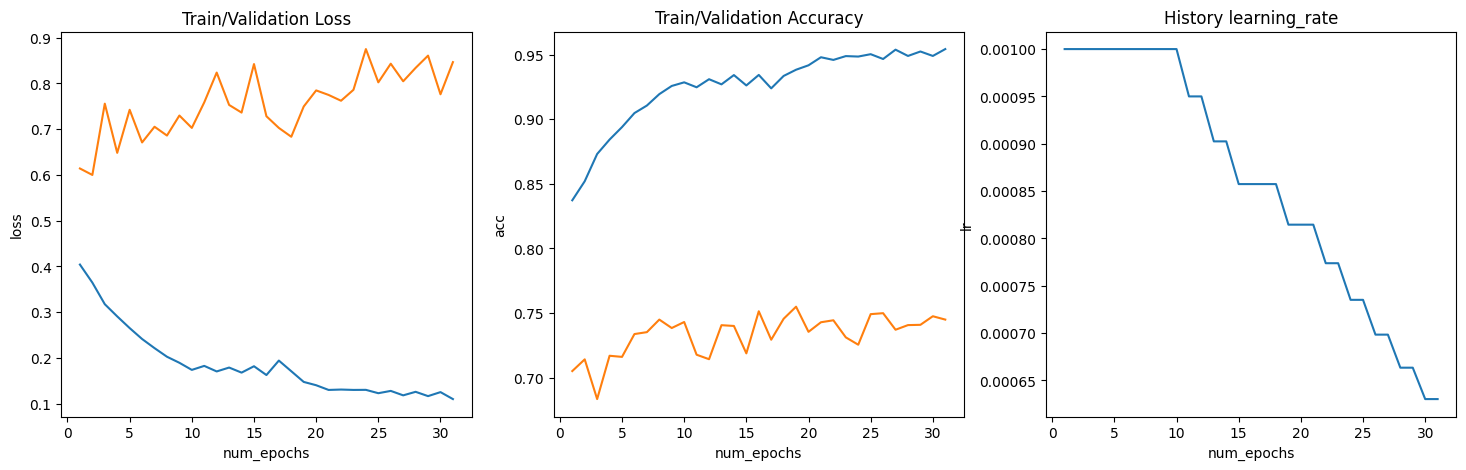

In [ ]:
train_ephs = len(hist_train_loss)
losses = (hist_train_loss, hist_valid_loss)
accuracy = (hist_train_acc, hist_valid_acc)
plot_graph(train_ephs, losses, accuracy, hist_lr)

## Next with accuracy

In [ ]:
def accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    preds = torch.argmax(preds, dim=1)

    correct = (preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
N_EPOCHS = 50
EPS = 0.85


JDUN_TRAIN = 1
JDUN_END = 7

try:
  if best_valid_loss and best_valid_acc:
    pass
except:
    best_valid_loss = float('inf')
    best_valid_acc = 0.

hist_train_loss, hist_valid_loss, hist_train_acc, hist_valid_acc = [], [], [], []
hist_lr = []

path_bestacc_model = 'best_acc_model.pt'
path_bestloss_model = 'best_loss_model.pt'

wait_train = 0
wait2end = 0

model_saved = True

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc, ep_lr = train(model, training_loader, optimizer,
                                         lr_scheduler, criterion, accuracy)
    hist_train_loss.append(train_loss)
    hist_train_acc.append(train_acc)

    valid_loss, valid_acc = evaluate(model, valid_loader, criterion,
                                     accuracy)
    hist_valid_loss.append(valid_loss)
    hist_valid_acc.append(valid_acc)
    hist_lr.append(ep_lr)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    text_add = ''
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path_bestloss_model)

        model_saved = True
        text_add = ' - save best_loss_model'
        wait2end = 0
        wait_train = 0
        k = 0

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), path_bestacc_model)

        model_saved = True
        text_add += ' - save best_acc_model'
        wait2end = 0
        wait_train = 0
        k = 1

    else:
        wait_train+=1


    if wait_train > JDUN_TRAIN and model_saved:
       if k == 0:
         model.load_state_dict(torch.load(path_bestloss_model))
         text_add = ' - load best_loss_model'
         k = 1
       elif k == 1:
         model.load_state_dict(torch.load(path_bestacc_model))
         text_add = ' - load best_acc_model'
         k = 0

       LR_RATE *= EPS
       lr_scheduler = optim.lr_scheduler.CyclicLR(optimizer,
                                                  base_lr=LR_RATE,
                                                  max_lr=LR_RATE*3,
                                                  step_size_up = 3,
                                                  mode="exp_range",
                                                  gamma=0.85)
       wait_train = 0
       wait2end+=1

    print(f'Epoch: {epoch+1:02} | with lr: {ep_lr:.9f} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain_Loss: {train_loss:.3f} | Train_Acc: {train_acc*100:.2f}%  Val_Loss: {valid_loss:.3f} | Val_Acc: {valid_acc*100:.2f}%' + text_add)

    if wait2end > JDUN_END:

      if k == 0:
        model.load_state_dict(torch.load(path_bestloss_model))
        text_add = ' - load best_loss_model'

      elif k == 1:
        model.load_state_dict(torch.load(path_bestacc_model))
        text_add = ' - load best_acc_model'

      print('Stop train, do not best fitness'+ text_add)

      break

515it [00:57,  8.99it/s]


Epoch: 01 | with lr: 0.000598737 | Epoch Time: 17m 39s
	Train_Loss: 0.121 | Train_Acc: 95.50%  Val_Loss: 0.860 | Val_Acc: 78.32% - save best_acc_model


515it [00:56,  9.12it/s]


Epoch: 02 | with lr: 0.000598737 | Epoch Time: 17m 32s
	Train_Loss: 0.107 | Train_Acc: 96.03%  Val_Loss: 0.873 | Val_Acc: 79.63% - save best_acc_model


515it [00:57,  8.95it/s]


Epoch: 03 | with lr: 0.000598737 | Epoch Time: 17m 13s
	Train_Loss: 0.104 | Train_Acc: 96.22%  Val_Loss: 0.791 | Val_Acc: 79.98% - save best_acc_model


515it [00:57,  8.98it/s]


Epoch: 04 | with lr: 0.000598737 | Epoch Time: 17m 32s
	Train_Loss: 0.100 | Train_Acc: 96.34%  Val_Loss: 0.926 | Val_Acc: 77.16%


515it [00:57,  8.97it/s]


Epoch: 05 | with lr: 0.000598737 | Epoch Time: 17m 30s
	Train_Loss: 0.089 | Train_Acc: 96.79%  Val_Loss: 0.849 | Val_Acc: 79.37% - load best_acc_model


515it [00:57,  8.95it/s]


Epoch: 06 | with lr: 0.000508926 | Epoch Time: 17m 36s
	Train_Loss: 0.091 | Train_Acc: 96.61%  Val_Loss: 0.907 | Val_Acc: 77.51%


515it [00:57,  8.94it/s]


Epoch: 07 | with lr: 0.000508926 | Epoch Time: 17m 31s
	Train_Loss: 0.087 | Train_Acc: 96.83%  Val_Loss: 0.898 | Val_Acc: 78.51% - load best_loss_model


515it [00:57,  8.95it/s]


Epoch: 08 | with lr: 0.000432587 | Epoch Time: 17m 38s
	Train_Loss: 0.276 | Train_Acc: 89.53%  Val_Loss: 0.614 | Val_Acc: 77.66%


515it [00:57,  8.95it/s]


Epoch: 09 | with lr: 0.000432587 | Epoch Time: 17m 41s
	Train_Loss: 0.242 | Train_Acc: 91.00%  Val_Loss: 0.712 | Val_Acc: 75.86% - load best_acc_model


515it [00:57,  8.92it/s]


Epoch: 10 | with lr: 0.000367699 | Epoch Time: 17m 37s
	Train_Loss: 0.082 | Train_Acc: 97.04%  Val_Loss: 0.840 | Val_Acc: 80.58% - save best_acc_model


515it [00:57,  8.95it/s]


Epoch: 11 | with lr: 0.000367699 | Epoch Time: 17m 44s
	Train_Loss: 0.075 | Train_Acc: 97.24%  Val_Loss: 0.879 | Val_Acc: 79.39%


515it [00:57,  8.94it/s]


Epoch: 12 | with lr: 0.000367699 | Epoch Time: 17m 40s
	Train_Loss: 0.071 | Train_Acc: 97.36%  Val_Loss: 0.905 | Val_Acc: 80.52% - load best_acc_model


515it [00:57,  8.92it/s]


Epoch: 13 | with lr: 0.000312544 | Epoch Time: 17m 38s
	Train_Loss: 0.072 | Train_Acc: 97.25%  Val_Loss: 0.876 | Val_Acc: 80.19%


515it [00:55,  9.26it/s]


Epoch: 14 | with lr: 0.000312544 | Epoch Time: 17m 15s
	Train_Loss: 0.067 | Train_Acc: 97.60%  Val_Loss: 0.871 | Val_Acc: 80.90% - save best_acc_model


515it [00:55,  9.26it/s]


Epoch: 15 | with lr: 0.000312544 | Epoch Time: 17m 5s
	Train_Loss: 0.063 | Train_Acc: 97.74%  Val_Loss: 0.925 | Val_Acc: 80.24%


515it [00:55,  9.25it/s]


Epoch: 16 | with lr: 0.000312544 | Epoch Time: 17m 6s
	Train_Loss: 0.060 | Train_Acc: 97.84%  Val_Loss: 0.962 | Val_Acc: 79.44% - load best_acc_model


515it [00:55,  9.29it/s]


Epoch: 17 | with lr: 0.000265663 | Epoch Time: 17m 5s
	Train_Loss: 0.061 | Train_Acc: 97.73%  Val_Loss: 0.939 | Val_Acc: 80.31%


515it [00:57,  8.93it/s]


Epoch: 18 | with lr: 0.000265663 | Epoch Time: 17m 18s
	Train_Loss: 0.059 | Train_Acc: 97.80%  Val_Loss: 0.962 | Val_Acc: 80.53% - load best_loss_model


515it [00:57,  8.97it/s]


Epoch: 19 | with lr: 0.000225813 | Epoch Time: 17m 32s
	Train_Loss: 0.262 | Train_Acc: 90.14%  Val_Loss: 0.725 | Val_Acc: 75.69%


515it [00:57,  9.01it/s]


Epoch: 20 | with lr: 0.000225813 | Epoch Time: 17m 29s
	Train_Loss: 0.230 | Train_Acc: 91.32%  Val_Loss: 0.650 | Val_Acc: 78.58% - load best_acc_model


515it [00:56,  9.09it/s]


Epoch: 21 | with lr: 0.000191941 | Epoch Time: 17m 35s
	Train_Loss: 0.059 | Train_Acc: 97.83%  Val_Loss: 0.953 | Val_Acc: 79.90%


515it [00:55,  9.22it/s]


Epoch: 22 | with lr: 0.000191941 | Epoch Time: 17m 18s
	Train_Loss: 0.055 | Train_Acc: 97.95%  Val_Loss: 0.983 | Val_Acc: 79.95% - load best_loss_model


515it [00:55,  9.22it/s]


Epoch: 23 | with lr: 0.000163150 | Epoch Time: 17m 11s
	Train_Loss: 0.260 | Train_Acc: 90.35%  Val_Loss: 0.660 | Val_Acc: 76.48%


515it [00:55,  9.23it/s]


Epoch: 24 | with lr: 0.000163150 | Epoch Time: 17m 5s
	Train_Loss: 0.234 | Train_Acc: 91.17%  Val_Loss: 0.704 | Val_Acc: 77.05% - load best_acc_model


515it [00:56,  9.16it/s]


Epoch: 25 | with lr: 0.000138678 | Epoch Time: 17m 10s
	Train_Loss: 0.058 | Train_Acc: 97.89%  Val_Loss: 0.952 | Val_Acc: 80.30%


515it [00:57,  8.96it/s]


Epoch: 26 | with lr: 0.000138678 | Epoch Time: 17m 23s
	Train_Loss: 0.053 | Train_Acc: 97.99%  Val_Loss: 0.950 | Val_Acc: 80.30% - load best_loss_model


515it [00:57,  8.97it/s]


Epoch: 27 | with lr: 0.000117876 | Epoch Time: 17m 27s
	Train_Loss: 0.258 | Train_Acc: 90.25%  Val_Loss: 0.655 | Val_Acc: 78.11%


515it [00:57,  8.94it/s]


Epoch: 28 | with lr: 0.000117876 | Epoch Time: 17m 25s
	Train_Loss: 0.235 | Train_Acc: 91.18%  Val_Loss: 0.708 | Val_Acc: 76.94% - load best_acc_model


515it [00:57,  8.97it/s]


Epoch: 29 | with lr: 0.000100195 | Epoch Time: 17m 27s
	Train_Loss: 0.058 | Train_Acc: 97.91%  Val_Loss: 0.925 | Val_Acc: 80.87%


515it [00:55,  9.29it/s]


Epoch: 30 | with lr: 0.000100195 | Epoch Time: 16m 58s
	Train_Loss: 0.053 | Train_Acc: 98.16%  Val_Loss: 0.960 | Val_Acc: 80.34% - load best_loss_model
Stop train, do not best fitness - load best_acc_model


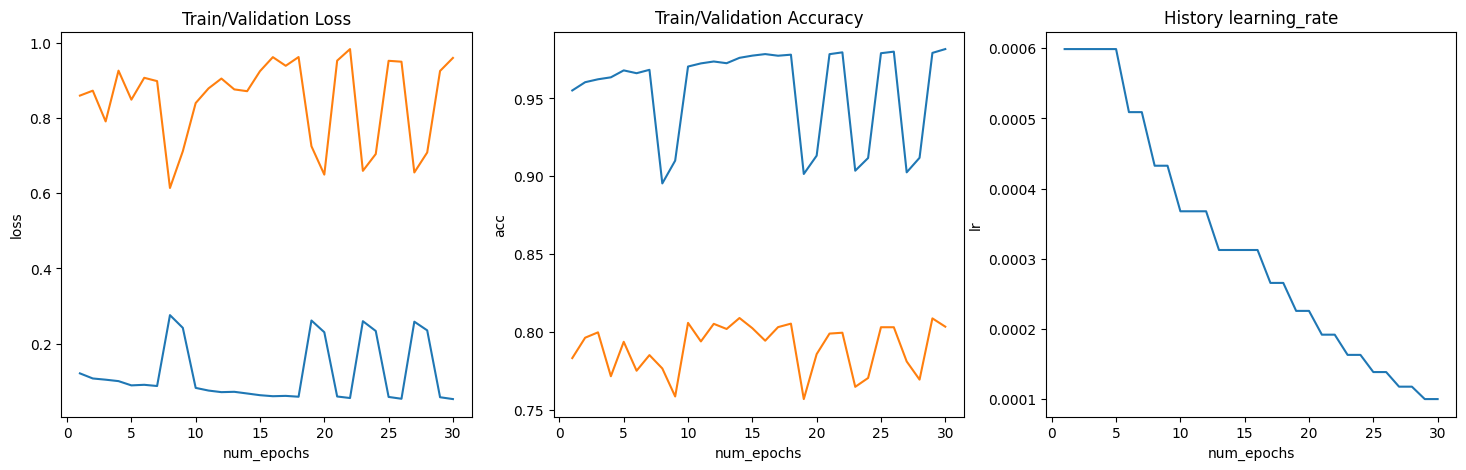

In [ ]:
train_ephs = len(hist_train_loss)
losses = (hist_train_loss, hist_valid_loss)
accuracy = (hist_train_acc, hist_valid_acc)
plot_graph(train_ephs, losses, accuracy, hist_lr)

# Run with Augmentation

In [ ]:
def predict_both(model, iterator):

    ### Testing
    model.eval()

    predicts = []
    y_true = []

    with torch.no_grad():
          for _, data in tqdm(enumerate(iterator, 0)):
            # Put data to target device
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device,
                                                       dtype = torch.long)

            targets = data['targets']

            outputs = model(ids, mask, token_type_ids)
            test_pred = torch.softmax(outputs, dim=1)
            test_pred = torch.argmax(test_pred, dim=1)

            # 3. Caculate loss/accuracy
            predicts.append(test_pred.cpu().numpy())
            y_true.append(targets.cpu().numpy())

    return np.hstack(predicts), np.hstack(y_true)

load

In [ ]:
load_dir = '/content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/NLP_course/DZ/Text_classification/Roberta/'

In [ ]:
k = 1
if k == 0:
  model.load_state_dict(torch.load(load_dir + 'best_loss_model.pt'))
  text_add = ' - best_loss_model'
  model_saved = True

elif k == 1:
  model.load_state_dict(torch.load(load_dir + 'best_acc_model.pt'))
  text_add = ' - best_acc_model'
  model_saved = True
print('load' + text_add)

load - best_acc_model


In [ ]:
!pip install nlpaug -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 3.6 MB/s eta 0:00:00


In [ ]:
import nlpaug
import nlpaug.augmenter.word as naw
import random

In [ ]:
AUG =[
       naw.SynonymAug(aug_src='wordnet', aug_min=1, aug_max=2),
       #naw.ContextualWordEmbsAug(model_path='bert-base-multilingual-uncased', aug_p=0.07)  # ДОЛГО - закомитил
       ]



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
class SentimentData_1(Dataset):
    """
    add augmentation
    """
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe

        self.text = self.data.Text_clean
        self.targets = self.data.Label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = random.choice(AUG).augment(self.text[index])
        text = str(text)
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
def get_randpart(data, params, part = 0.5):
    data, _ = train_test_split(data,
                              stratify= data.Label,
                              test_size=part)

    data = data.reset_index(drop=True)

    data_set =  SentimentData_1(data, tokenizer, MAX_LEN)
    data_loader = DataLoader(data_set, **params)
    return data_loader

In [ ]:
from sklearn.model_selection import train_test_split
SEED = 200
train_size = 0.8
MAX_LEN = 126

train_data, valid_data = train_test_split(new_df,
                                          stratify= new_df.Label,
                                          test_size=0.2,
                                          random_state=SEED)

In [ ]:
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 16

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

valid_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = get_randpart(data = train_data, params = train_params)
valid_loader =  get_randpart(data = valid_data, params =  valid_params)

In [ ]:
dataiter = iter(training_loader)
sample = next(dataiter)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
print('Sample ids input size', sample['ids'].size())
print('Sample mask input: \n', sample['mask'].size())
print('Sample token_type_ids input: \n', sample['token_type_ids'].size())
print('Sample targets input: \n', sample['targets'].size())
print('\nSample ids input size', sample['ids'])
print('Sample label: \n', sample['targets'])

Sample ids input size torch.Size([32, 126])
Sample mask input: 
 torch.Size([32, 126])
Sample token_type_ids input: 
 torch.Size([32, 126])
Sample targets input: 
 torch.Size([32])

Sample ids input size tensor([[    0, 48759, 13841,  ...,     1,     1,     1],
        [    0, 48759, 42390,  ...,     1,     1,     1],
        [    0, 48759, 37818,  ...,     1,     1,     1],
        ...,
        [    0, 48759,  3762,  ...,     1,     1,     1],
        [    0, 48759, 16431,  ...,     1,     1,     1],
        [    0, 48759,  3972,  ...,     1,     1,     1]])
Sample label: 
 tensor([0., 1., 1., 0., 4., 0., 2., 4., 0., 4., 3., 0., 3., 3., 1., 0., 0., 3.,
        2., 1., 2., 4., 0., 0., 1., 0., 1., 4., 1., 4., 4., 4.])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LR_RATE = 0.0009
optimizer = optim.SGD(model.parameters(), lr=LR_RATE)

lr_scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR_RATE, max_lr=LR_RATE*3,
                                           step_size_up=5,mode="exp_range",gamma=0.85)

In [ ]:
# Calculate class frequencies
class_frequencies = main_ds.Label.value_counts().sort_index()

# Calculate class weights inversely proportional to class frequencies
total_samples = len(main_ds)
class_weights = total_samples / (len(class_frequencies) * class_frequencies)

# Convert class weights to a PyTorch tensor
class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float)

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
N_EPOCHS = 50
EPS = 0.85


JDUN_TRAIN = 1
JDUN_END = 5

try:
  if best_valid_loss and best_valid_acc:
    pass
except:
    best_valid_loss = float('inf')
    best_valid_acc = 0.

hist_train_loss, hist_valid_loss, hist_train_acc, hist_valid_acc = [], [], [], []
hist_lr = []

save_dir = '/content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/NLP_course/DZ/Text_classification/Roberta/'
path_bestacc_model = save_dir + 'best_acc_aug_model.pt'
path_bestloss_model = save_dir + 'best_loss_aug_model.pt'


wait_train = 0
wait2end = 0

model_saved = True

for epoch in range(N_EPOCHS):
    start_time = time.time()

    # take again rand half_part from train_data, valid_data
    training_loader = get_randpart(data = train_data, params = train_params)
    valid_loader =  get_randpart(data = valid_data, params =  valid_params)

    train_loss, train_acc, ep_lr = train(model, training_loader, optimizer,
                                         lr_scheduler, criterion, f1_accuracy)
    hist_train_loss.append(train_loss)
    hist_train_acc.append(train_acc)

    valid_loss, valid_acc = evaluate(model, valid_loader, criterion,
                                     f1_accuracy)
    hist_valid_loss.append(valid_loss)
    hist_valid_acc.append(valid_acc)
    hist_lr.append(ep_lr)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    text_add = ''
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path_bestloss_model)

        model_saved = True
        text_add = ' - save best_loss_model'
        wait2end = 0
        wait_train = 0
        k = 0

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), path_bestacc_model)

        model_saved = True
        text_add += ' - save best_acc_model'
        wait2end = 0
        wait_train = 0
        k = 1

    else:
        wait_train+=1


    if wait_train > JDUN_TRAIN and model_saved:
       if k == 0:
         model.load_state_dict(torch.load(path_bestloss_model))
         text_add = ' - load best_loss_model'
         k = 1
       elif k == 1:
         model.load_state_dict(torch.load(path_bestacc_model))
         text_add = ' - load best_acc_model'
         k = 0

       LR_RATE *= EPS
       lr_scheduler = optim.lr_scheduler.CyclicLR(optimizer,
                                                  base_lr=LR_RATE,
                                                  max_lr=LR_RATE*3,
                                                  step_size_up = 3,
                                                  mode="exp_range",
                                                  gamma=0.85)
       wait_train = 0
       wait2end+=1

    print(f'Epoch: {epoch+1:02} | with lr: {ep_lr:.9f} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain_Loss: {train_loss:.3f} | Train_Acc: {train_acc*100:.2f}%  Val_Loss: {valid_loss:.3f} | Val_Acc: {valid_acc*100:.2f}%' + text_add)

    if wait2end > JDUN_END:

      if k == 0:
        model.load_state_dict(torch.load(path_bestloss_model))
        text_add = ' - load best_loss_model'

      elif k == 1:
        model.load_state_dict(torch.load(path_bestacc_model))
        text_add = ' - load best_acc_model'

      print('Stop train, do not best fitness'+ text_add)

      break

258it [00:40,  6.38it/s]


Epoch: 01 | with lr: 0.000900000 | Epoch Time: 12m 54s
	Train_Loss: 0.407 | Train_Acc: 85.62%  Val_Loss: 0.512 | Val_Acc: 75.08%


258it [00:39,  6.57it/s]


Epoch: 02 | with lr: 0.000900000 | Epoch Time: 12m 36s
	Train_Loss: 0.391 | Train_Acc: 86.02%  Val_Loss: 0.420 | Val_Acc: 81.21% - save best_acc_model


258it [00:39,  6.47it/s]


Epoch: 03 | with lr: 0.000900000 | Epoch Time: 12m 45s
	Train_Loss: 0.365 | Train_Acc: 86.70%  Val_Loss: 0.401 | Val_Acc: 81.32% - save best_loss_model - save best_acc_model


258it [00:38,  6.66it/s]


Epoch: 04 | with lr: 0.000900000 | Epoch Time: 12m 46s
	Train_Loss: 0.372 | Train_Acc: 86.97%  Val_Loss: 0.406 | Val_Acc: 81.05%


258it [00:39,  6.47it/s]


Epoch: 05 | with lr: 0.000900000 | Epoch Time: 12m 48s
	Train_Loss: 0.355 | Train_Acc: 87.44%  Val_Loss: 0.363 | Val_Acc: 82.70% - save best_loss_model - save best_acc_model


258it [00:39,  6.53it/s]


Epoch: 06 | with lr: 0.000900000 | Epoch Time: 12m 58s
	Train_Loss: 0.335 | Train_Acc: 88.24%  Val_Loss: 0.406 | Val_Acc: 81.82%


258it [00:39,  6.48it/s]


Epoch: 07 | with lr: 0.000900000 | Epoch Time: 12m 59s
	Train_Loss: 0.336 | Train_Acc: 88.41%  Val_Loss: 0.481 | Val_Acc: 77.48% - load best_acc_model


258it [00:40,  6.44it/s]


Epoch: 08 | with lr: 0.000765000 | Epoch Time: 12m 59s
	Train_Loss: 0.337 | Train_Acc: 88.03%  Val_Loss: 0.395 | Val_Acc: 81.54%


258it [00:39,  6.47it/s]


Epoch: 09 | with lr: 0.000765000 | Epoch Time: 13m 2s
	Train_Loss: 0.342 | Train_Acc: 87.86%  Val_Loss: 0.358 | Val_Acc: 82.07% - save best_loss_model


258it [00:39,  6.53it/s]


Epoch: 10 | with lr: 0.000765000 | Epoch Time: 13m 4s
	Train_Loss: 0.325 | Train_Acc: 88.63%  Val_Loss: 0.354 | Val_Acc: 83.44% - save best_loss_model - save best_acc_model


258it [00:39,  6.47it/s]


Epoch: 11 | with lr: 0.000765000 | Epoch Time: 13m 5s
	Train_Loss: 0.318 | Train_Acc: 88.73%  Val_Loss: 0.417 | Val_Acc: 81.72%


258it [00:39,  6.55it/s]


Epoch: 12 | with lr: 0.000765000 | Epoch Time: 13m 3s
	Train_Loss: 0.308 | Train_Acc: 89.35%  Val_Loss: 0.431 | Val_Acc: 79.68% - load best_acc_model


258it [00:40,  6.36it/s]


Epoch: 13 | with lr: 0.000650250 | Epoch Time: 13m 10s
	Train_Loss: 0.320 | Train_Acc: 88.61%  Val_Loss: 0.425 | Val_Acc: 80.45%


258it [00:39,  6.56it/s]


Epoch: 14 | with lr: 0.000650250 | Epoch Time: 13m 10s
	Train_Loss: 0.306 | Train_Acc: 89.36%  Val_Loss: 0.416 | Val_Acc: 80.71% - load best_loss_model


258it [00:39,  6.54it/s]


Epoch: 15 | with lr: 0.000552712 | Epoch Time: 13m 13s
	Train_Loss: 0.300 | Train_Acc: 89.15%  Val_Loss: 0.390 | Val_Acc: 81.67%


258it [00:39,  6.46it/s]


Epoch: 16 | with lr: 0.000552712 | Epoch Time: 13m 17s
	Train_Loss: 0.298 | Train_Acc: 89.41%  Val_Loss: 0.426 | Val_Acc: 80.30% - load best_acc_model


258it [00:39,  6.51it/s]


Epoch: 17 | with lr: 0.000469806 | Epoch Time: 13m 17s
	Train_Loss: 0.313 | Train_Acc: 88.70%  Val_Loss: 0.394 | Val_Acc: 81.10%


258it [00:39,  6.57it/s]


Epoch: 18 | with lr: 0.000469806 | Epoch Time: 13m 16s
	Train_Loss: 0.288 | Train_Acc: 89.87%  Val_Loss: 0.430 | Val_Acc: 79.80% - load best_loss_model


258it [00:39,  6.57it/s]


Epoch: 19 | with lr: 0.000399335 | Epoch Time: 13m 15s
	Train_Loss: 0.299 | Train_Acc: 89.77%  Val_Loss: 0.381 | Val_Acc: 82.27%


258it [00:39,  6.54it/s]


Epoch: 20 | with lr: 0.000399335 | Epoch Time: 13m 17s
	Train_Loss: 0.290 | Train_Acc: 90.13%  Val_Loss: 0.379 | Val_Acc: 81.83% - load best_acc_model
 23%|██▎       | 117/515 [02:53<10:03,  1.52s/it, stats=train_loss: 0.2948]

К сожалению гугл забанил!!

# Run with Augmentation and lr_wise
https://stackoverflow.com/questions/51801648/how-to-apply-layer-wise-learning-rate-in-pytorch

In [ ]:
l = [module for module in model.modules() if not isinstance(module, nn.Sequential)]
l

[Roberta_Class(
   (roberta): RobertaModel(
     (embeddings): RobertaEmbeddings(
       (word_embeddings): Embedding(50265, 768, padding_idx=1)
       (position_embeddings): Embedding(514, 768, padding_idx=1)
       (token_type_embeddings): Embedding(1, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (encoder): RobertaEncoder(
       (layer): ModuleList(
         (0-11): 12 x RobertaLayer(
           (attention): RobertaAttention(
             (self): RobertaSelfAttention(
               (query): Linear(in_features=768, out_features=768, bias=True)
               (key): Linear(in_features=768, out_features=768, bias=True)
               (value): Linear(in_features=768, out_features=768, bias=True)
               (dropout): Dropout(p=0.1, inplace=False)
             )
             (output): RobertaSelfOutput(
               (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [ ]:

LR_RATE = 0.001

optimizer = optim.SGD(
    [
        {"params": model.roberta.pooler.parameters(), "lr": LR_RATE*0.1*0.001},
        {"params": model.pre_classifier.parameters(), "lr": LR_RATE*0.1},
        {"params": model.classifier.parameters(), "lr": LR_RATE},
    ],
    lr=LR_RATE,
)

lr_scheduler = optim.lr_scheduler.CyclicLR(optimizer,
                                           base_lr=LR_RATE,
                                           max_lr=LR_RATE*3,
                                           step_size_up=5,
                                           mode="exp_range",
                                           gamma=0.85)

In [ ]:
# Calculate class frequencies
class_frequencies = main_ds.Label.value_counts().sort_index()

# Calculate class weights inversely proportional to class frequencies
total_samples = len(main_ds)
class_weights = total_samples / (len(class_frequencies) * class_frequencies)

# Convert class weights to a PyTorch tensor
class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
N_EPOCHS = 40
EPS = 0.85


JDUN_TRAIN = 1
JDUN_END = 5

try:
  if best_valid_loss and best_valid_acc:
    pass
except:
    best_valid_loss = 0.35 #float('inf')
    best_valid_acc = 0.8643

hist_train_loss, hist_valid_loss, hist_train_acc, hist_valid_acc = [], [], [], []
hist_lr = []

save_dir = '/content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/NLP_course/DZ/Text_classification/Roberta/'
path_bestacc_model = save_dir + 'best_acc_aug_model_layer_wise.pt'
path_bestloss_model = save_dir + 'best_loss_aug_model_layer_wise.pt'


wait_train = 0
wait2end = 0

model_loss_saved = False
model_acc_saved = True

for epoch in range(N_EPOCHS):
    start_time = time.time()

    # take again rand half_part from train_data, valid_data
    training_loader = get_randpart(data = train_data, params = train_params)
    valid_loader =  get_randpart(data = valid_data, params =  valid_params)

    train_loss, train_acc, ep_lr = train(model, training_loader, optimizer,
                                         lr_scheduler, criterion, accuracy)
    hist_train_loss.append(train_loss)
    hist_train_acc.append(train_acc)

    valid_loss, valid_acc = evaluate(model, valid_loader, criterion,
                                     accuracy)
    hist_valid_loss.append(valid_loss)
    hist_valid_acc.append(valid_acc)
    hist_lr.append(ep_lr)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    text_add = ''
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path_bestloss_model)

        model_loss_saved = True
        text_add = ' - save best_loss_model'
        wait2end = 0
        wait_train = 0
        k = 0

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), path_bestacc_model)

        model_acc_saved = True
        text_add += ' - save best_acc_model'
        wait2end = 0
        wait_train = 0
        k = 1

    else:
        wait_train+=1


    if wait_train > JDUN_TRAIN:
       if model_loss_saved and k == 0:
         model.load_state_dict(torch.load(path_bestloss_model))
         text_add = ' - load best_loss_model'
         k = 1
       elif model_acc_saved and k == 1:
         model.load_state_dict(torch.load(path_bestacc_model))
         text_add = ' - load best_acc_model'
         k = 0

       LR_RATE *= EPS
       lr_scheduler = optim.lr_scheduler.CyclicLR(optimizer,
                                                  base_lr=LR_RATE,
                                                  max_lr=LR_RATE*3,
                                                  step_size_up = 3,
                                                  mode="exp_range",
                                                  gamma=0.85)
       wait_train = 0
       wait2end+=1

    print(f'Epoch: {epoch+1:02} | with lr: {ep_lr:.9f} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain_Loss: {train_loss:.3f} | Train_Acc: {train_acc*100:.2f}%  Val_Loss: {valid_loss:.3f} | Val_Acc: {valid_acc*100:.2f}%' + text_add)

    if wait2end > JDUN_END:

      if k == 0:
        model.load_state_dict(torch.load(path_bestloss_model))
        text_add = ' - load best_loss_model'

      elif k == 1:
        model.load_state_dict(torch.load(path_bestacc_model))
        text_add = ' - load best_acc_model'

      print('Stop train, do not best fitness'+ text_add)

      break

258it [00:37,  6.87it/s]


Epoch: 01 | with lr: 0.000722500 | Epoch Time: 12m 25s
	Train_Loss: 0.407 | Train_Acc: 86.72%  Val_Loss: 0.416 | Val_Acc: 86.14%


258it [00:38,  6.71it/s]


Epoch: 02 | with lr: 0.000722500 | Epoch Time: 12m 28s
	Train_Loss: 0.412 | Train_Acc: 86.49%  Val_Loss: 0.443 | Val_Acc: 85.25%


258it [00:37,  6.81it/s]


Epoch: 03 | with lr: 0.000614125 | Epoch Time: 12m 28s
	Train_Loss: 0.410 | Train_Acc: 86.51%  Val_Loss: 0.421 | Val_Acc: 86.34%


258it [00:39,  6.59it/s]


Epoch: 04 | with lr: 0.000614125 | Epoch Time: 12m 33s
	Train_Loss: 0.409 | Train_Acc: 86.61%  Val_Loss: 0.433 | Val_Acc: 85.22%


258it [00:39,  6.54it/s]


Epoch: 05 | with lr: 0.000522006 | Epoch Time: 12m 39s
	Train_Loss: 0.413 | Train_Acc: 86.50%  Val_Loss: 0.420 | Val_Acc: 85.95%


258it [00:37,  6.79it/s]


Epoch: 06 | with lr: 0.000522006 | Epoch Time: 12m 33s
	Train_Loss: 0.420 | Train_Acc: 86.42%  Val_Loss: 0.399 | Val_Acc: 86.36%


258it [00:38,  6.77it/s]


Epoch: 07 | with lr: 0.000443705 | Epoch Time: 12m 33s
	Train_Loss: 0.414 | Train_Acc: 86.58%  Val_Loss: 0.421 | Val_Acc: 85.71%


258it [00:38,  6.75it/s]


Epoch: 08 | with lr: 0.000443705 | Epoch Time: 12m 34s
	Train_Loss: 0.411 | Train_Acc: 86.57%  Val_Loss: 0.404 | Val_Acc: 86.53% - save best_acc_model


258it [00:38,  6.72it/s]


Epoch: 09 | with lr: 0.000443705 | Epoch Time: 12m 36s
	Train_Loss: 0.421 | Train_Acc: 86.42%  Val_Loss: 0.413 | Val_Acc: 85.85%


258it [00:38,  6.76it/s]


Epoch: 10 | with lr: 0.000443705 | Epoch Time: 12m 35s
	Train_Loss: 0.402 | Train_Acc: 86.79%  Val_Loss: 0.447 | Val_Acc: 85.25% - load best_acc_model


258it [00:38,  6.75it/s]


Epoch: 11 | with lr: 0.000377150 | Epoch Time: 12m 37s
	Train_Loss: 0.407 | Train_Acc: 86.89%  Val_Loss: 0.417 | Val_Acc: 86.09%


258it [00:38,  6.69it/s]


Epoch: 12 | with lr: 0.000377150 | Epoch Time: 12m 43s
	Train_Loss: 0.421 | Train_Acc: 86.27%  Val_Loss: 0.398 | Val_Acc: 86.63% - save best_acc_model


258it [00:37,  6.82it/s]


Epoch: 13 | with lr: 0.000377150 | Epoch Time: 12m 53s
	Train_Loss: 0.414 | Train_Acc: 86.33%  Val_Loss: 0.445 | Val_Acc: 85.30%


258it [00:40,  6.42it/s]


Epoch: 14 | with lr: 0.000377150 | Epoch Time: 12m 43s
	Train_Loss: 0.406 | Train_Acc: 86.65%  Val_Loss: 0.423 | Val_Acc: 86.02% - load best_acc_model


258it [00:38,  6.68it/s]


Epoch: 15 | with lr: 0.000320577 | Epoch Time: 12m 45s
	Train_Loss: 0.411 | Train_Acc: 86.67%  Val_Loss: 0.439 | Val_Acc: 85.47%


258it [00:37,  6.80it/s]


Epoch: 16 | with lr: 0.000320577 | Epoch Time: 12m 44s
	Train_Loss: 0.409 | Train_Acc: 86.66%  Val_Loss: 0.401 | Val_Acc: 86.22%


258it [00:38,  6.79it/s]


Epoch: 17 | with lr: 0.000272491 | Epoch Time: 12m 56s
	Train_Loss: 0.410 | Train_Acc: 86.73%  Val_Loss: 0.416 | Val_Acc: 86.31%


258it [00:38,  6.74it/s]


Epoch: 18 | with lr: 0.000272491 | Epoch Time: 12m 37s
	Train_Loss: 0.404 | Train_Acc: 86.70%  Val_Loss: 0.416 | Val_Acc: 86.39%


258it [00:37,  6.89it/s]


Epoch: 19 | with lr: 0.000231617 | Epoch Time: 12m 36s
	Train_Loss: 0.416 | Train_Acc: 86.36%  Val_Loss: 0.415 | Val_Acc: 86.29%


258it [00:37,  6.87it/s]


Epoch: 20 | with lr: 0.000231617 | Epoch Time: 12m 38s
	Train_Loss: 0.420 | Train_Acc: 86.60%  Val_Loss: 0.416 | Val_Acc: 86.19%


258it [00:38,  6.74it/s]


Epoch: 21 | with lr: 0.000196874 | Epoch Time: 12m 39s
	Train_Loss: 0.414 | Train_Acc: 86.37%  Val_Loss: 0.400 | Val_Acc: 86.26%


258it [00:37,  6.90it/s]


Epoch: 22 | with lr: 0.000196874 | Epoch Time: 12m 39s
	Train_Loss: 0.400 | Train_Acc: 86.97%  Val_Loss: 0.431 | Val_Acc: 85.49%


258it [00:37,  6.81it/s]


Epoch: 23 | with lr: 0.000167343 | Epoch Time: 12m 38s
	Train_Loss: 0.405 | Train_Acc: 86.80%  Val_Loss: 0.433 | Val_Acc: 85.68%


258it [00:38,  6.78it/s]

Epoch: 24 | with lr: 0.000167343 | Epoch Time: 12m 40s
	Train_Loss: 0.401 | Train_Acc: 86.81%  Val_Loss: 0.412 | Val_Acc: 86.56%


FileNotFoundError: ignored

Запуск после перерыва

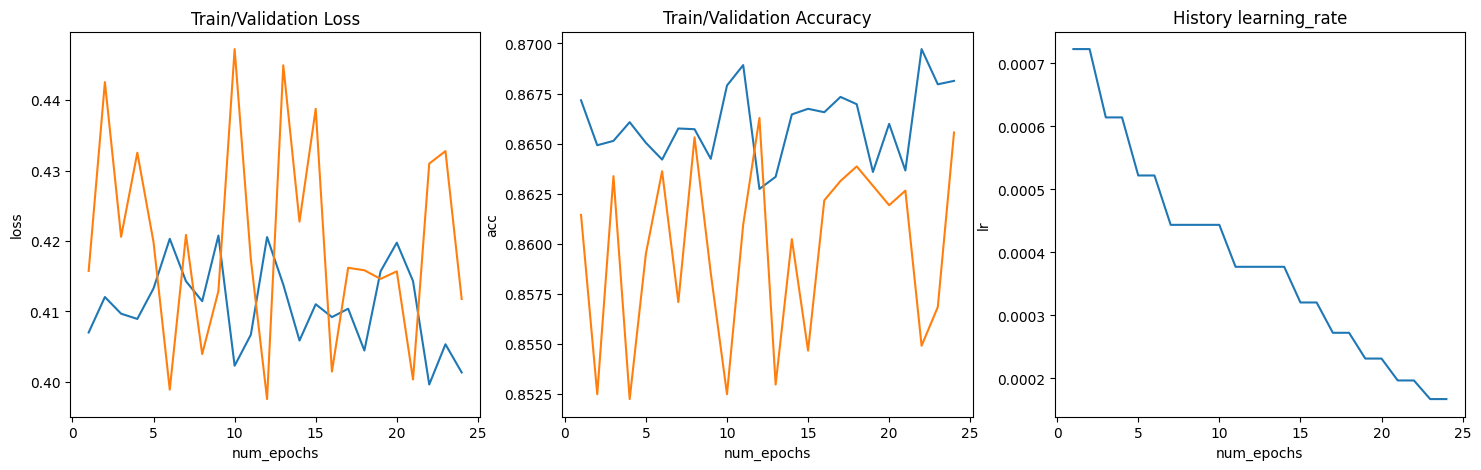

In [ ]:
train_ephs = len(hist_train_loss)
losses = (hist_train_loss, hist_valid_loss)
accuracy = (hist_train_acc, hist_valid_acc)
plot_graph(train_ephs, losses, accuracy, hist_lr)

# Plot_confusion_matrix

In [ ]:
def confusion_matrix(y_true, y_pred, labels=None, normalize=None,
                     cmap="Blues", encoded_labels=True,
                     plot=True, verbose = False):
    """
    Args:
        y_true (ndarray)
        y_pred (ndarray)
        labels (list)
        normalise (str) : {'all', None}
        cmap (maplotlib.pyplot.cmap)
        encoded_labels (bool): Need to be False if labels are not one hot encoded
        plot (bool): If False, plot will not appear for confusion matrix

    Return:
        conf_mat (tuple): TN, FP, FN, TP
    """

    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    if normalize not in ('all', None):
        raise ValueError("normalize must be one of {'all', None}")

    conf_labels = None if encoded_labels else labels
    fmt = 'g' if normalize == None else '.2%'

    conf_mat = confusion_matrix(y_true, y_pred, normalize=normalize, labels=conf_labels)

    if plot:
        plt.figure(figsize = (10,10))
        ax = sns.heatmap(conf_mat, cmap=cmap,
                         square=True, cbar=False,
                         annot=True, fmt=fmt,
                         annot_kws={'fontsize': 15,
                                    'fontweight': 'bold',
                                    'fontfamily': 'serif',
                                    }
                         )
        ax.set_title("Confusion Matrix", fontsize=18)
        ax.set_xlabel("Predicted", fontsize=11, color = "red")
        ax.set_ylabel("Actual", fontsize=11, color = "red")
        if labels != None:
            ax.set_yticklabels(labels,  fontsize=12)
            ax.set_xticklabels(labels,  fontsize=12)
    if verbose: return conf_mat

In [ ]:
pred_lbls, y_val_lbls = predict_both(model, valid_loader)

258it [00:39,  6.61it/s]


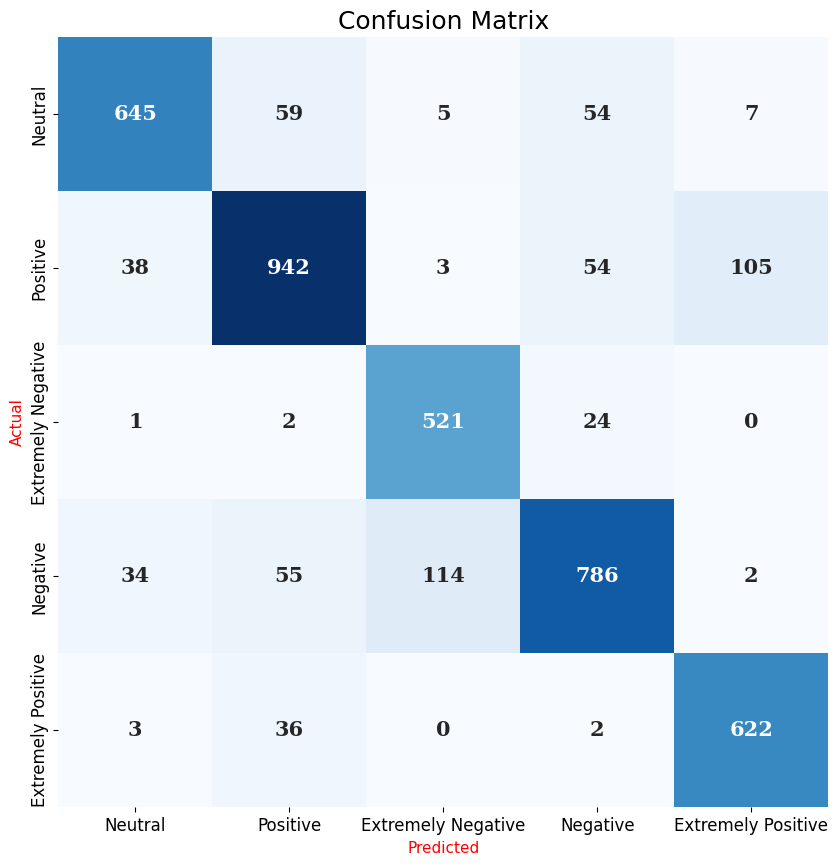

In [ ]:
confusion_matrix(y_val_lbls, pred_lbls, labels=dict_sent_to_lbl.keys())#, normalize='all')

# Predict test

In [ ]:
sentiments = []

model.eval()
with torch.inference_mode():
    for i, row in tqdm(test_ds.iterrows(), total=test_ds.shape[0]):

        # Cleanup and tokenize the sentence
        text = row['Text_clean']

        inputs = tokenizer.encode_plus(
                                        text,
                                        None,
                                        add_special_tokens=True,
                                        max_length=MAX_LEN,
                                        pad_to_max_length=True,
                                        return_token_type_ids=True
                                    )
        # get input_ids, attention_mask, token_type_ids
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        input_ids = torch.tensor([input_ids], dtype=torch.long).to(device)
        attention_mask = torch.tensor([attention_mask], dtype=torch.long).to(device)
        token_type_ids = torch.tensor([token_type_ids], dtype=torch.long).to(device)


        # Get predictions
        logits = model(input_ids,
                       attention_mask=attention_mask,
                       token_type_ids = token_type_ids)
        pred = torch.argmax(logits, 1)
        # Convert the integer category value to its actual name and save in predictions list
        sentiments.append(dict_lbl_to_sent[pred.item()])

# Save the predictions in Pandas column
test_ds['Sentiment'] = sentiments

100%|██████████| 3798/3798 [00:50<00:00, 75.05it/s]


In [ ]:
sample_submission.Sentiment = test_ds['Sentiment'].values
sample_submission.head()

,id,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,Negative
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,Positive
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Extremely Positive
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Extremely Negative
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,Neutral


# Сабмит в Kaggle сразу

In [ ]:
file_name = 'submission.csv'
# сохраняем с колонкой Id
sample_submission.to_csv(file_name, index=False)

Старый для проб

In [ ]:
!kaggle competitions submit -c nlp-txt-classification -f submission.csv -m "from colab_tests"

100% 184k/184k [00:02<00:00, 63.5kB/s]
Successfully submitted to Unit 3 - Text Classification

Основной

In [ ]:
!kaggle competitions submit -c unit-3-nlp-txt-classification -f submission.csv -m "From colab - Roberta_1"

100% 183k/183k [00:04<00:00, 44.6kB/s]
Successfully submitted to Unit 3 - Классификация текстов